# ARIMA model

__Steps:__
1. Draw data plot
2. Check ACF and PACF
3. Make our TS stationary
4. Choose hyperparameter $p$, $i$, $q$
5. Train ARIMA model
6. Visualize model predictions

For this lab let's use [Rossmann Store Sales dataset](https://www.kaggle.com/c/rossmann-store-sales)

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data preprocessing and drawing

In [105]:
train = pd.read_csv('./train.csv', index_col='Date', parse_dates = True, low_memory=False)

train.shape

(1017209, 8)

In [106]:
train

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1


This dataset has 1115 stores and sales for them, because we don't need to solve this competition, this will be to much for us. So we will choose one store, let's it be 2 store.

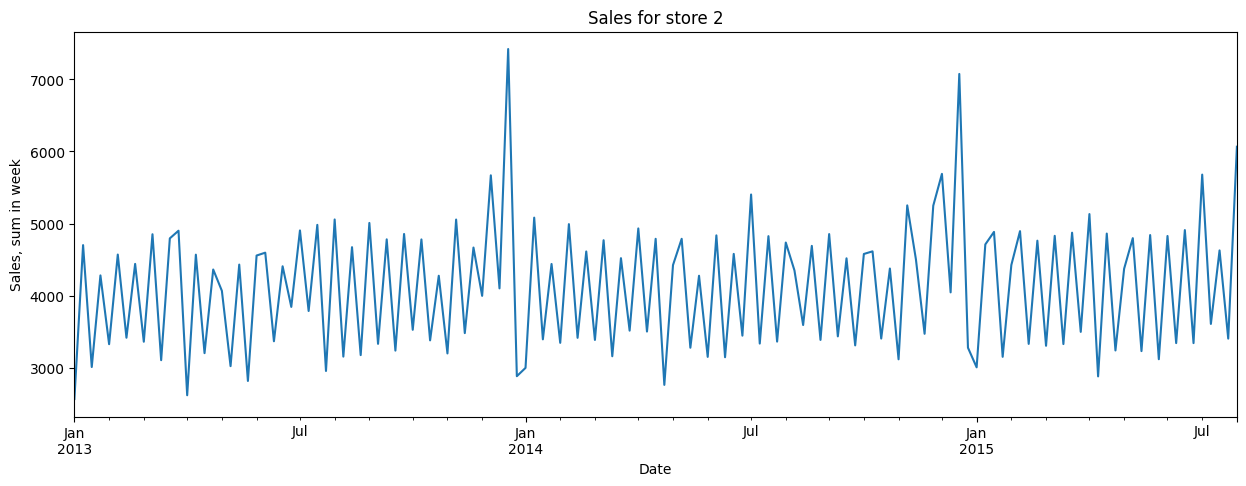

In [107]:
sales = train[train.Store == 2]['Sales']
sales.astype(float)

f, ax = plt.subplots(1, figsize = (15, 5))
ax.set_ylabel("Sales, sum in week")
ax.set_title("Sales for store 2")
sales.resample('W').mean().plot(ax=ax)
plt.show()

### Stationary

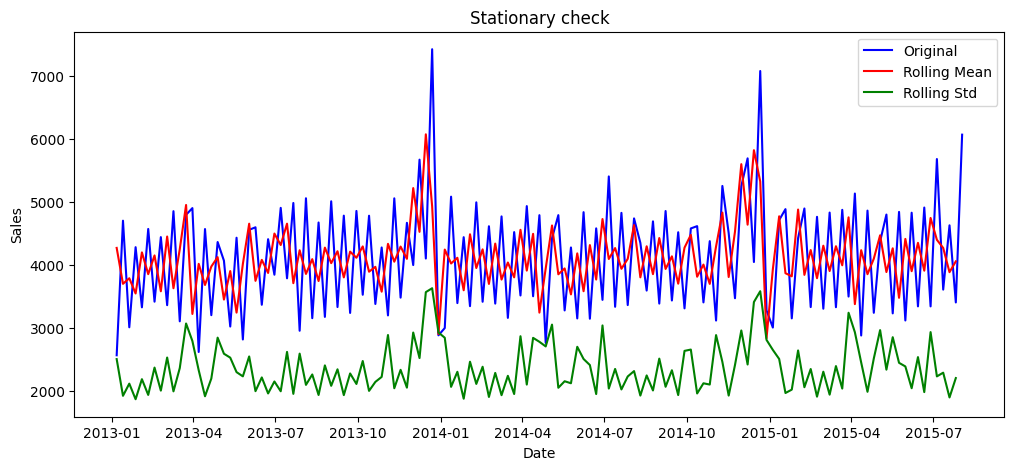

Results of Dickey-Fuller Test:
ADF Statistic: -6.218237
p-value: 0.000000


In [108]:
from statsmodels.tsa.stattools import adfuller

roll_mean = sales.rolling(window=7).mean()
roll_std = sales.rolling(window=7).std()

plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_title("Stationary check")

orig = plt.plot(sales.resample('W').mean(), color='blue',label='Original')
mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.show(block=False)

print('Results of Dickey-Fuller Test:')
result = adfuller(sales, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

Base on 0 p-value we can conclude that time sires is stationary.

### ACF and PACF

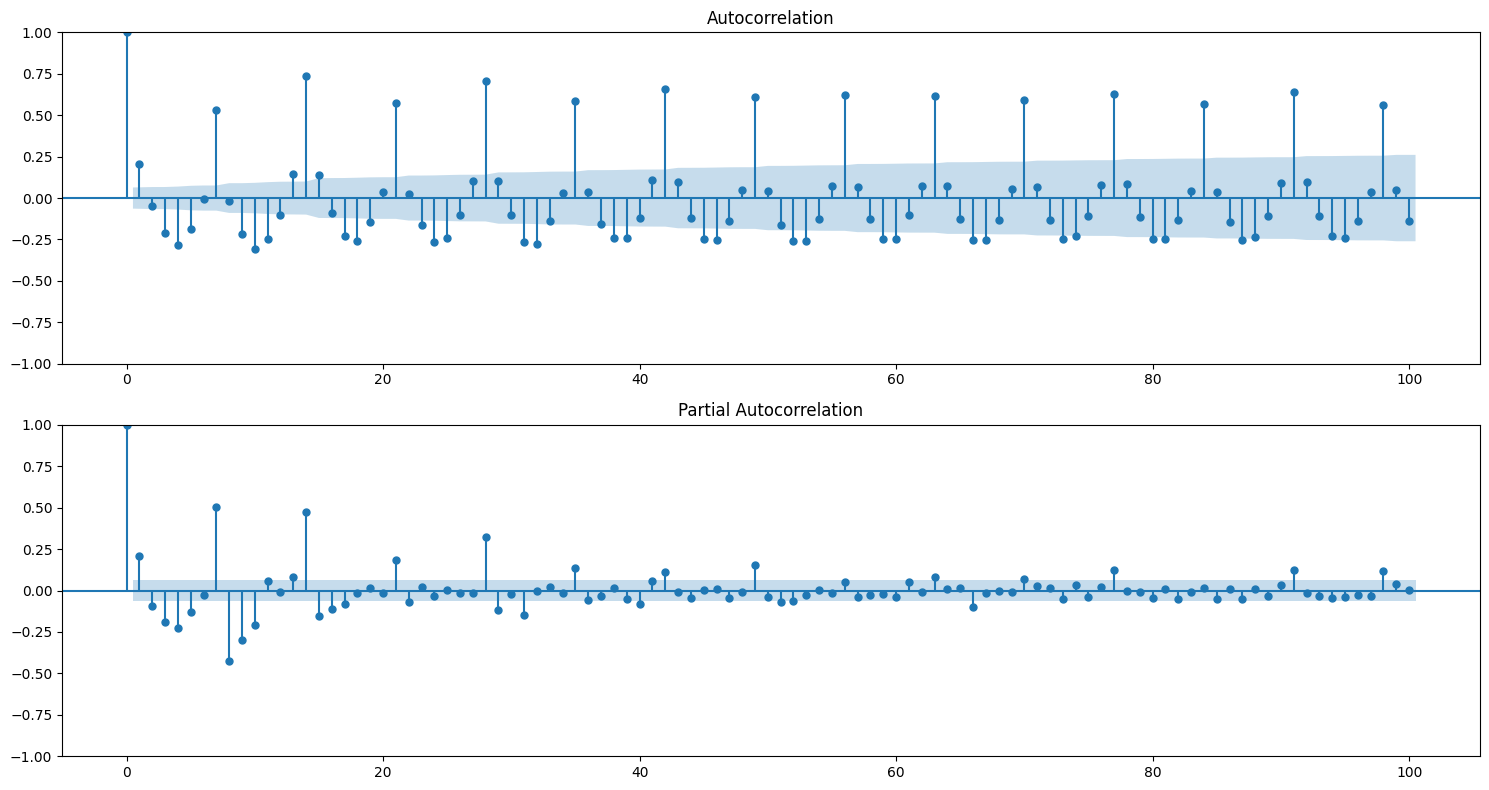

In [109]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

lag_acf = 100
lag_pacf = 100

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
plot_acf(sales, lags=lag_acf, ax=ax[0])
plot_pacf(sales, lags=lag_pacf, ax=ax[1], method='ols')


plt.tight_layout()
plt.show()

We can use PACF plot for choosing p (AR part) and ACF plot for choosing q (MA part). From plots we can see that we can use p=2 and q=2, but also we can use p=9 and q=8. Both values in the plot have significant values.

### Search Hyperparameter

In [110]:
!pip install pmdarima

from pmdarima.arima.utils import ndiffs

In [111]:
# Another proof that our ts is stationary
ndiffs(sales, test='adf')

0

### Train ARIMA

In [112]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sales.resample("W").mean(), order=(2, 0, 2))
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  135
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1078.740
Date:                Wed, 20 Dec 2023   AIC                           2169.480
Time:                        20:45:09   BIC                           2186.912
Sample:                    01-06-2013   HQIC                          2176.564
                         - 08-02-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4125.4575     71.067     58.050      0.000    3986.169    4264.746
ar.L1          0.0187      0.491      0.038      0.970      -0.944       0.981
ar.L2          0.4721      0.407      1.160      0.246      -0.326       1.270
ma.L1         -0.5400      0.501     -1.078      0.281      -1.522       0.442
ma.L2         -0.0229      0.252     -0.091      0.928      -0.516       0.470
sigma2      5.224e+05   4.58e+04     11.413      0.000    4.33e+05    6.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                97.42
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.82
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

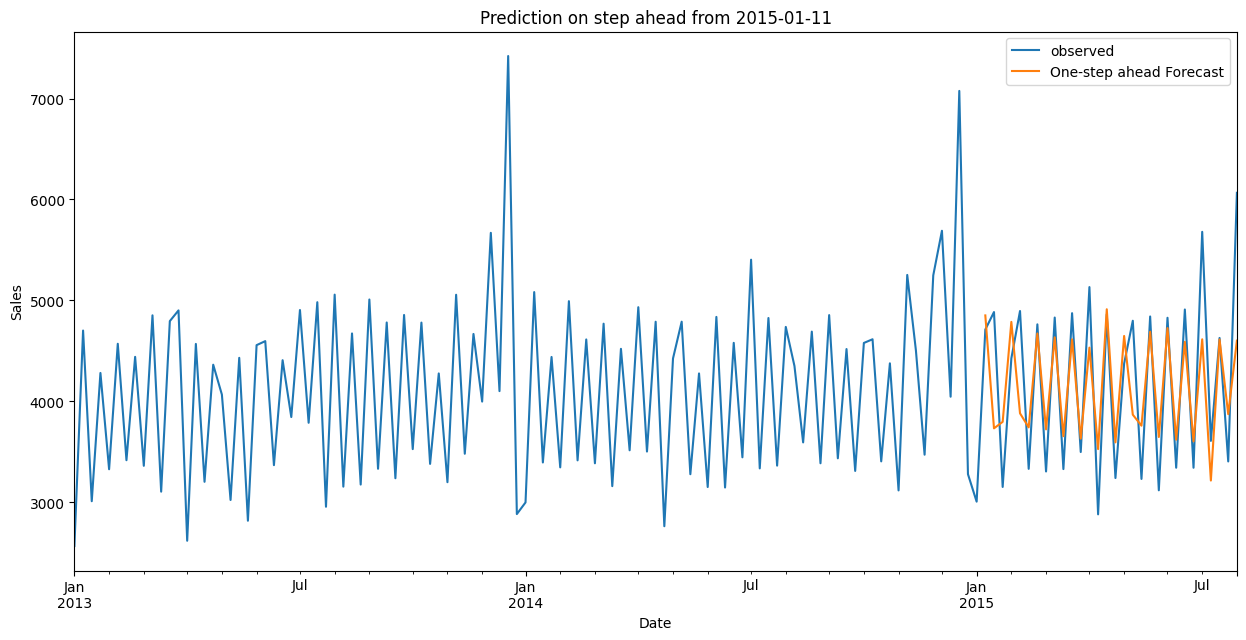

In [113]:
pred = result.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic = False) 

ax = sales.resample('W').mean().plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_title("Prediction on step ahead from 2015-01-11")

plt.legend()
plt.show()

prediction = pred.predicted_mean
truth = sales["2015-01-11":].resample('W').mean()

### Results and conclusions

In [114]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"MAE: {mean_absolute_error(truth, prediction):.3f}")
print(f"R2: {r2_score(truth, prediction):.3f}")

MAE: 609.411
R2: 0.148


Constructed model work quite nice. For example XGBoost approach for this dataset has $MAE = 1191.9$, with is significantly higher. We can reach better results SARIMA models, because our data have visible seasonable pattern and also nice results can give Profit model. But for basic approach ARIMA work very good.